In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

## Dependencies

In [2]:
from functools import partial
from itertools import product
from copy import deepcopy
import typing
import time
import sys
import pickle
import os

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import benchmark, GenericOuterHook, PredictionErrorHook
from mazelab_experimenter.utils import compute_optimal_value


# Result output format.
FILE_FORMAT = 'pdf'
OUTPUT_FORMAT = 'figures/ablation_{}.' + FILE_FORMAT

print("Output figures will be formatted as:", OUTPUT_FORMAT.format("FILENAME"))

Output figures will be formatted as: figures/ablation_FILENAME.pdf


## Environment Definition

We explore simple gridworld environments presenting tabular features to the agents. We test our agents on an empty world and on a world with rooms, we keep the dimensionality small due to memory requirements incurred by either the hindsight tables or eligibility trace models.

The agents/ environments are initialized with a binary reward function, i.e., a function that always returns $0$ until a desired state is reached upon which it returns $1$.

In [3]:
t = 10_000  # Number of steps before terminating an episode for any agent on all environments.

name_grid10 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

name_grid20 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=22, width=22),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[20, 20]]
    ),
    time_limit=t,
    override=True
)

name_rooms4 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=4, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[7, 7]]
    ),
    time_limit=t,
    override=True
)

name_rooms9 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=9, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[13, 13]]
    ),
    time_limit=t,
    override=True
)

name_mazeS = EnvRegister.register(
    maze_type='fixed_maze', 
    name=f'maze-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(large=False),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[11, 11]]
    ),
    time_limit=t,
    override=True
)

name_mazeL = EnvRegister.register(
    maze_type='fixed_maze', 
    name=f'maze-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(large=True),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[19, 19]]
    ),
    time_limit=t,
    override=True
)

# Collect each individual environment.
environment_names = [name_grid10, name_grid20, name_rooms4, name_rooms9, name_mazeS, name_mazeL]
environment_labels = ['10x10 Gridworld', '20x20 Gridworld', '4-rooms 5-to-1', '9-rooms 5-to-1', '10x10 Maze', '20x20 Maze']

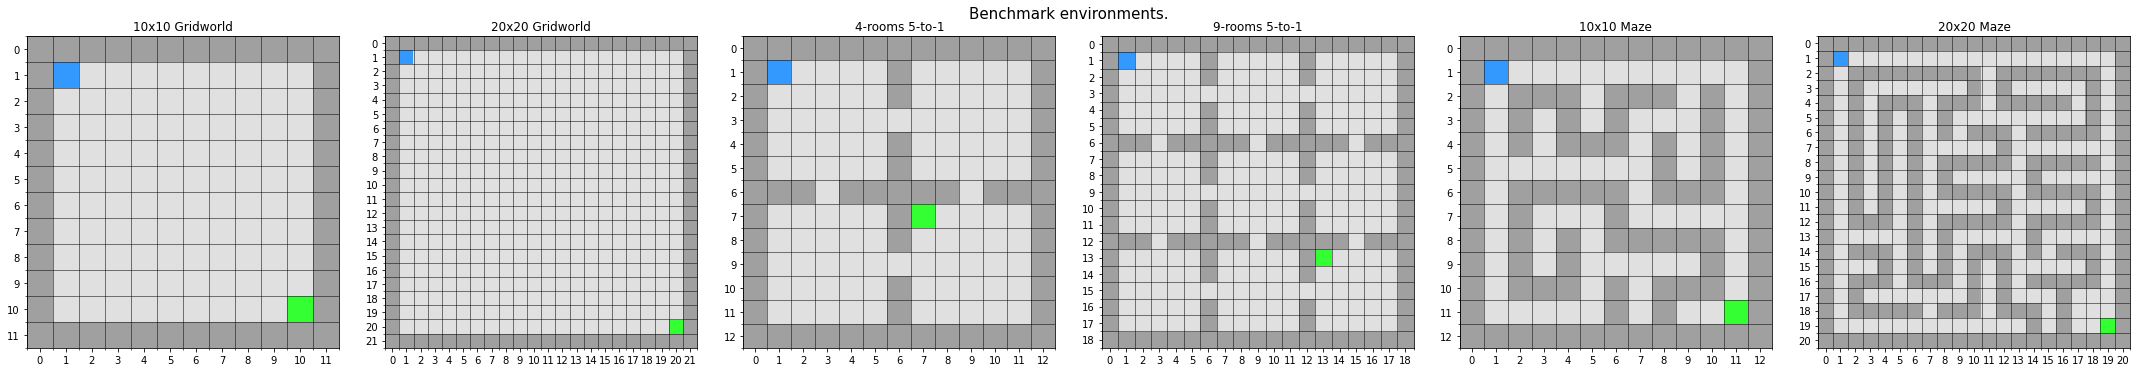

In [4]:
# Create and show an example visualization of the environment
dummy_images = list()
for name in environment_names:
    dummy = gym.make(name)
    dummy.reset()
    
    dummy_images.append(dummy.unwrapped.get_image())
    dummy.close()
    
fig, ax = plt.subplots(1, len(environment_names), figsize=(5 * len(environment_names), 5))
for i, img in enumerate(dummy_images):
    # Plot image with border padding
    ax[i].imshow(img)
    
    # Grid lines
    major, minor = np.arange(0, len(img), 1), np.arange(-.5, len(img), 1)
    ax[i].set_xticks(major); ax[i].set_yticks(major)            # Major plot ticks
    ax[i].set_xticklabels(major); ax[i].set_yticklabels(major)  # Major plot tick-labels
    ax[i].set_xticks(minor, minor=True); ax[i].set_yticks(minor, minor=True)  # Minor ticks for Grid-lines.
    
    ax[i].grid(which='minor', color='black', linestyle='-', linewidth=.5)
    
    # Annotations
    ax[i].set_title(environment_labels[i])

plt.suptitle("Benchmark environments.", fontsize=15)
plt.tight_layout()

plt.savefig(OUTPUT_FORMAT.format('BenchmarkEnvironment', FILE_FORMAT), format=FILE_FORMAT, bbox_inches="tight")
plt.show()

# Visualize Performance Experiment

In [18]:
benchmark_data = list()
for e in environment_names:  # The Large environments
    print(e)
    l = [x for x in os.listdir('results/MCLambda') if e in x and 'performance']
    if l:
        n = 'results/MCLambda/'+ l[-1]
        print(n)
        with open(n, 'rb') as f:
            benchmark_data += pickle.load(f)

gridworld-v0
results/MCLambda/GT_performance_ablation_gridworld-v0_1641204799.out
gridworld-v1
results/MCLambda/GT_performance_ablation_gridworld-v1_1641214930.out
n_rooms-v0
results/MCLambda/GT_performance_ablation_n_rooms-v0_1641205425.out
n_rooms-v1
results/MCLambda/GT_performance_ablation_n_rooms-v1_1641210237.out
maze-v0
results/MCLambda/GT_performance_ablation_maze-v0_1641206090.out
maze-v1
results/MCLambda/GT_performance_ablation_maze-v1_1641218882.out


In [19]:
benchmark_data[0]['meta'] + benchmark_data[1]['meta']

[{'atomic': False,
  'decay': 1.0,
  'n_levels': 5,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  'n_levels': 4,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  'n_levels': 3,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  'n_levels': 2,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  'n_levels': 1,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  'n_levels': 5,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  'n_levels': 4,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  'n_levels': 3,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  'n_levels': 2,
  'greedy_options': True,
  'greedy_training': False},
 {'atomic': False,
  'decay': 1.0,
  

In [71]:
benchmark_data[4]['meta'] += benchmark_data[5]['meta']
benchmark_data[4]['data'] += benchmark_data[5]['data']

In [55]:
print(len(benchmark_data[0]['data'][0]))

100


In [20]:
def plot_expectation(canvas, xs: np.ndarray, ydata: np.ndarray, repetition_size: int, axis: int = 0, label: str = None, color: str = None, style: str = None) -> None:
    # Helper function for plotting the mean performance with approximation error of the mean.
    mean = ydata[...,axis][..., 0].mean(axis=0)
    stderr = ydata[...,axis][..., 0].std(axis=0) / np.sqrt(repetition_size)

    canvas.plot(xs, mean, label=label, linewidth=2, linestyle=style, color=color)
#     canvas.fill_between(xs, mean + stderr, mean - stderr, alpha=0.1, color=color)
    

{'atomic': False, 'decay': 1.0, 'n_levels': 5, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 4, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 3, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 2, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 1, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 5, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 4, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 3, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 2, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0, 'n_levels': 1, 'greedy_options': True, 'greedy_training': False}
{'atomic': False, 'decay': 1.0

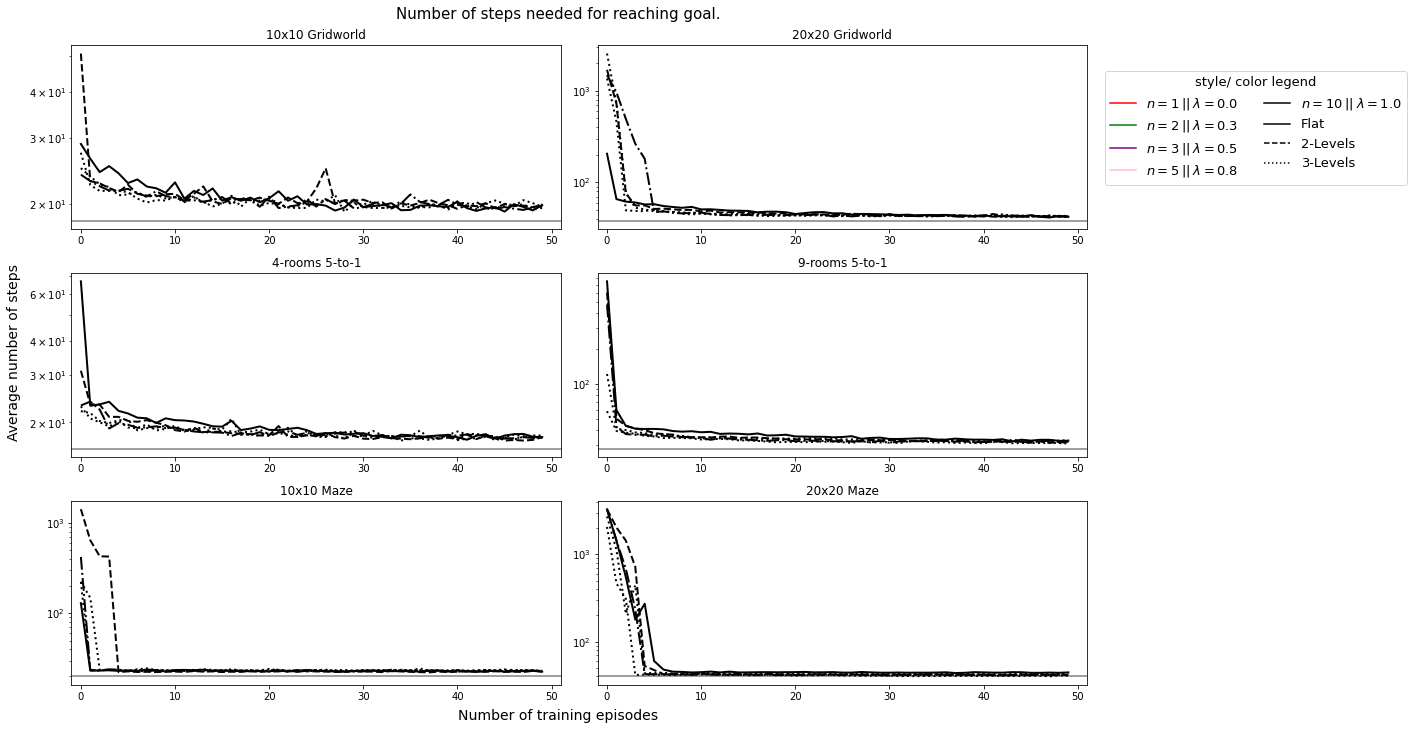

In [21]:
# Define some annotation helper functions
def get_style(**params: dict) -> str:
    v = {1: '-', 2: '--', 3: 'dotted', 4: '-.', 5: ':', 6: '-'}
    return v[params['n_levels']]


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'purple', 5: 'pink', 10: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.3: 'green', 0.5: 'purple', 0.8: 'pink', 1.0: 'black'}
        return d[params['decay']]


# Create figure
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i // 2, env_i % 2]
    
    minval = [18, 38, 16, 28, 20, 40][env_i]
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
        if 'n_steps' in meta[param_i]:
            continue
        if meta[param_i]['decay'] not in [1.0, 0.0]:
            continue
        if not meta[param_i]['greedy_options']:
            continue
#             if meta[param_i]['n_steps'] == 3:
#                 pass
#         else: continue
        print(meta[param_i])
      
        xs = np.arange(50)
        if meta[param_i]['atomic']:
            xs += len(xs) + 1
     
        plot_expectation(canvas, xs, np.asarray(arr), 100, axis, color=get_color(**meta[param_i]), style=get_style(**meta[param_i]))
        canvas.set_title(environment_labels[env_i])
        canvas.set_yscale('log')
        canvas.set_xlim([-1, 51])
    
    canvas.hlines(minval, -1, 51, color='grey')

    
# Add Legend
plt.plot([], [], color='red', label=r'$n=1 \: || \: \lambda = 0.0$')
plt.plot([], [], color='green', label=r'$n=2\: || \: \lambda = 0.3$')
plt.plot([], [], color='purple', label=r'$n=3\: || \: \lambda = 0.5$')
plt.plot([], [], color='pink', label=r'$n=5\: || \: \lambda = 0.8$')
plt.plot([], [], color='black', label=r'$n=10\: || \: \lambda = 1.0$')

plt.plot([], [], linestyle='-', color='black', label=r'Flat')
plt.plot([], [], linestyle='--', color='black', label=r'2-Levels')
plt.plot([], [], linestyle='dotted', color='black', label=r'3-Levels')

fig.legend(fontsize=13, ncol=2, title='style/ color legend', bbox_to_anchor=(1.0, 0.9), loc='upper left', title_fontsize=13)
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of training episodes', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Average number of steps', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps needed for reaching goal.", fontsize=15)

plt.tight_layout()
plt.show()

KeyError: 5

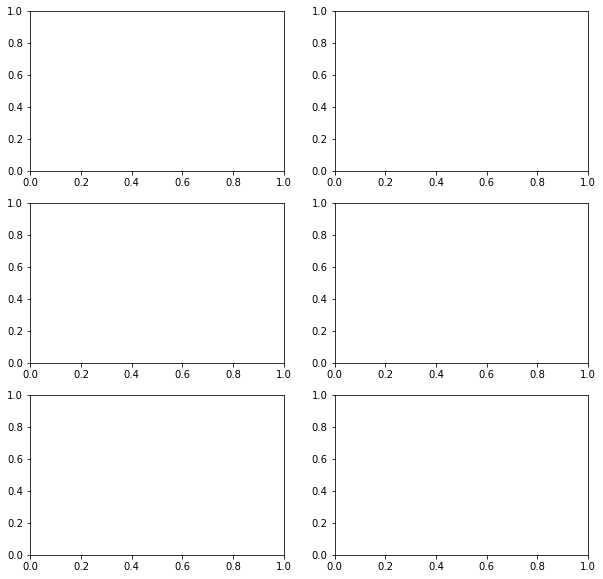

In [14]:
# Define some annotation helper functions
def get_style(**params: dict) -> str:
    v = {1: '-', 2: '--', 3: 'dotted'}
    return v[params['n_levels']]


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'purple', 5: 'pink', 10: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.3: 'green', 0.5: 'purple', 0.8: 'pink', 1.0: 'black'}
        return d[params['decay']]


# Create figure
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i // 2, env_i % 2]

    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
#         if meta[param_i]['hierarchical']:
           
#             if meta[param_i]['n_levels'] == 3:
#                 pass
#         else: continue
        
        xs = np.arange(50)
        if meta[param_i]['atomic']:
            xs += len(xs) + 1
    
        plot_expectation(canvas, xs, np.asarray(arr), 100, axis, color=get_color(**meta[param_i]), style=get_style(**meta[param_i]))
        canvas.set_title(environment_labels[env_i])
        canvas.set_yscale('log')

    
# Add Legend
plt.plot([], [], color='red', label=r'$n=1 \: || \: \lambda = 0.0$')
plt.plot([], [], color='green', label=r'$n=2\: || \: \lambda = 0.3$')
plt.plot([], [], color='purple', label=r'$n=3\: || \: \lambda = 0.5$')
plt.plot([], [], color='pink', label=r'$n=5\: || \: \lambda = 0.8$')
plt.plot([], [], color='black', label=r'$n=10\: || \: \lambda = 1.0$')

plt.plot([], [], linestyle='-', color='black', label=r'Flat')
plt.plot([], [], linestyle='--', color='black', label=r'2-Levels')
plt.plot([], [], linestyle='-.', color='black', label=r'3-Levels')

fig.legend(fontsize=13, ncol=2, title='style/ color legend', bbox_to_anchor=(1.0, 0.9), loc='upper left', title_fontsize=13)
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of training episodes', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Average number of steps', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps needed for reaching goal.", fontsize=15)

plt.tight_layout()
plt.show()

[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[14.67328193 17.16308835  6.52903806  5.08056188  4.83878076  0.        ]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[102.75780822 564.44808312 636.25678456 296.74216661 226.76049594
   0.        ]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[33.50174946 10.62622066  6.02840008  4.91966162  3.94869565  0.        ]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[374.15294614 200.36247073  30.63681756  95.15496     10.06365555
   0.        ]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[ 64.9640419  475.83677168  56.1030549   84.5690832   37.36015399
   0.        ]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0]
[1635.62885405 1095.76287196  679.09145897  656.81699821  343.21718938
    0.        ]


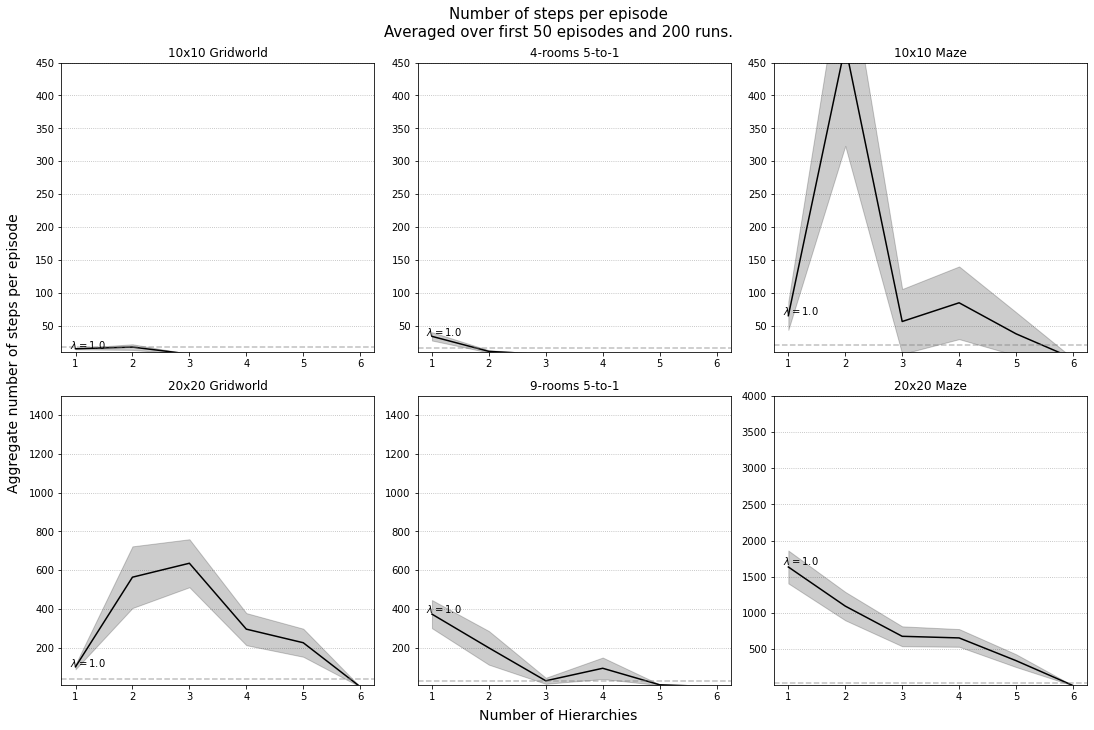

In [24]:
# Define some annotation helper functions
def get_style(**params: dict) -> str:
    v = {1: '-', 2: '--', 3: 'dotted'}
    return v[params['n_levels']]


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'blue', 5: 'purple', 10: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.3: 'green', 0.5: 'blue', 0.8: 'purple', 1.0: 'black'}
        return d[params['decay']]

        
def aggregate(arr: np.ndarray, cutoff: float = 5) -> float:
    episode_means = np.mean(arr, axis=-1)
    stderr = np.std(episode_means, axis=-1)
    mask = np.abs(episode_means - np.mean(episode_means)) < (cutoff * stderr)
    return np.mean(episode_means[mask]), (np.std(episode_means[mask]) / np.sqrt(sum(mask)))


# Create figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i % 2, env_i // 2]
    canvas.set_title(environment_labels[env_i])
    
    if not env_i % 2:
        canvas.set_ylim([10, 450])
    else:
        if env_i == 5:
            canvas.set_ylim([10, 4000])
        else:
            canvas.set_ylim([10, 1500])
    
    averages = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        4: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        5: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        6: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
    }
    stds = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        4: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        5: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
        6: {'decay': [0.] * 5, 'n_steps': [0.] * 5, 'count': [0.] * 5},
    }
    avg_flat = list()
    std_flat = list()
    
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
        m, s = aggregate(np.asarray(arr)[..., axis][:,0], cutoff=16)
        avg_flat.append(m)
        std_flat.append(s)
    
    
    p_decay = [0, 0.3, 0.5, 0.8, 1.0]
    p_n_steps = [1, 2, 3, 5, 8, 10]
    
    for param_i, (avg, std) in enumerate(zip(avg_flat, std_flat)):
        if meta[param_i]['greedy_options']:
#             continue
            pass

        n = meta[param_i]['n_levels']
        if 'decay' in meta[param_i]:
            m = {0.0: 0, 0.3: 1, 0.5: 2, 0.8: 3, 1.0: 4}
            averages[n]['decay'][m[meta[param_i]['decay']]] += avg #(averages[n]['decay'][m[meta[param_i]['decay']]])
            averages[n]['count'][m[meta[param_i]['decay']]] += 1
            stds[n]['decay'][m[meta[param_i]['decay']]] += std  #(stds[n]['decay'][m[meta[param_i]['decay']]])
            stds[n]['count'][m[meta[param_i]['decay']]] += 1
        else:
            m = {1: 0, 2: 1, 3: 2, 5: 3, 10: 4}
            averages[n]['n_steps'][m[meta[param_i]['n_steps']]] += (averages[n]['n_steps'][m[meta[param_i]['n_steps']]])
            stds[n]['n_steps'][m[meta[param_i]['n_steps']]] += (stds[n]['n_steps'][m[meta[param_i]['n_steps']]])
    
    minval = [18, 38, 16, 28, 20, 40][env_i]
    c = ['red', 'green', 'blue', 'purple', 'black']
    for x in range(len(c)):
        if x == 1: 
            continue
        
        decay = np.asarray([(v['decay'][x] / v['count'][x] if v['count'][x] else 0) for v in averages.values()])
#         n_steps = np.asarray([v['n_steps'][x] / v['count'][x] for v in averages.values()])
        
        edecay = np.asarray([(v['decay'][x] / v['count'][x] if v['count'][x] else 0) for v in stds.values()])
#         en_steps = np.asarray([v['n_steps'][x] / v['count'][x] for v in stds.values()])

        xs = np.arange(1, 7)
        canvas.plot(xs, decay, color=c[x])
        canvas.fill_between(xs, decay - edecay, decay + edecay, color=c[x], alpha=0.2)
        print(decay)
        canvas.annotate(fr'$\lambda={p_decay[x]}$',
            xy=(xs[0]*0.9, decay[0] * 1.02), xycoords='data', color=c[x])
        
        # Number of hierarchies x-ticks
        canvas.set_xticks(list(range(1, 7)))
        canvas.set_xticklabels([1, 2, 3, 4, 5, 6])
    
    canvas.axhline(minval, 0, 7, color='grey', linestyle='--', alpha=0.5)
    
    canvas.set_axisbelow(True)
    canvas.grid(axis='y', linestyle='dotted')    
    
#     canvas.set_yscale('log')
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of Hierarchies', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Aggregate number of steps per episode', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps per episode\nAveraged over first 50 episodes and 200 runs.", fontsize=15)

plt.tight_layout()
# plt.savefig('PerformanceResultsAggregate.pdf', format='pdf', bbox_inches="tight")
plt.show()

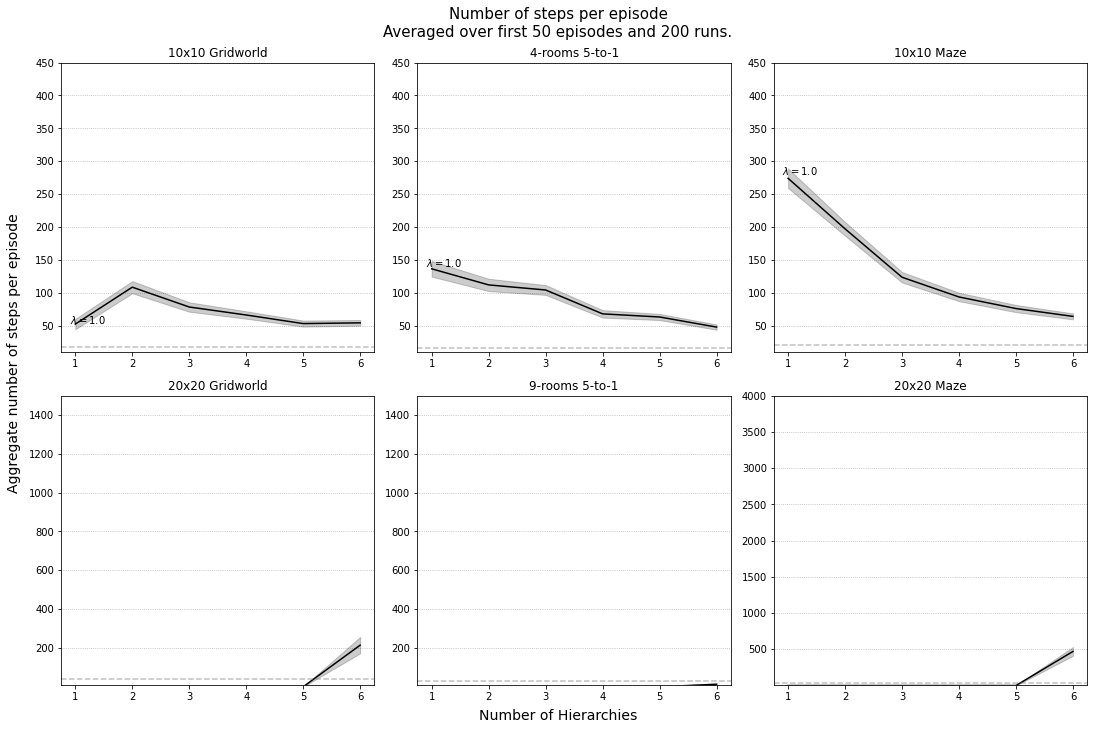

In [9]:
# Define some annotation helper functions
def get_style(**params: dict) -> str:
    v = {1: '-', 2: '--', 3: 'dotted'}
    return v[params['n_levels']]


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'blue', 5: 'purple', 10: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.3: 'green', 0.5: 'blue', 0.8: 'purple', 1.0: 'black'}
        return d[params['decay']]

        
def aggregate(arr: np.ndarray, cutoff: float = 5) -> float:
    episode_means = np.mean(arr, axis=-1)
    stderr = np.std(episode_means, axis=-1)
    mask = np.abs(episode_means - np.mean(episode_means)) < (cutoff * stderr)
    return np.mean(episode_means[mask]), (np.std(episode_means[mask]) / np.sqrt(sum(mask)))


# Create figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i % 2, env_i // 2]
    canvas.set_title(environment_labels[env_i])
    
    if not env_i % 2:
        canvas.set_ylim([10, 450])
    else:
        if env_i == 5:
            canvas.set_ylim([10, 4000])
        else:
            canvas.set_ylim([10, 1500])
    
    averages = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        4: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        5: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        6: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
    }
    stds = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        4: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        5: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        6: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
    }
    avg_flat = list()
    std_flat = list()
    
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
        m, s = aggregate(np.asarray(arr)[..., axis][:,0], cutoff=6)
        avg_flat.append(m)
        std_flat.append(s)
    
    
    p_decay = [0, 0.3, 0.5, 0.8, 1.0]
    p_n_steps = [1, 2, 3, 5, 8, 10]
    
    for param_i, (avg, std) in enumerate(zip(avg_flat, std_flat)):
        if meta[param_i]['greedy_options']:
#             continue
            pass
    
        n = meta[param_i]['n_levels']
        if 'decay' in meta[param_i]:
            m = {0.0: 0, 0.3: 1, 0.5: 2, 0.8: 3, 1.0: 4}
            averages[n]['decay'][m[meta[param_i]['decay']]] += (avg - averages[n]['decay'][m[meta[param_i]['decay']]])
            stds[n]['decay'][m[meta[param_i]['decay']]] += (std - stds[n]['decay'][m[meta[param_i]['decay']]])
        else:
            m = {1: 0, 2: 1, 3: 2, 5: 3, 10: 4}
            averages[n]['n_steps'][m[meta[param_i]['n_steps']]] += (avg - averages[n]['n_steps'][m[meta[param_i]['n_steps']]])
            stds[n]['n_steps'][m[meta[param_i]['n_steps']]] += (std - stds[n]['n_steps'][m[meta[param_i]['n_steps']]])
    
    minval = [18, 38, 16, 28, 20, 40][env_i]
    c = ['red', 'green', 'blue', 'purple', 'black']
    for x in range(len(c)):
        if x == 1: 
            continue
        
        decay = np.asarray([v['decay'][x] for v in averages.values()])
        n_steps = np.asarray([v['n_steps'][x] for v in averages.values()])
        
        edecay = np.asarray([v['decay'][x] for v in stds.values()])
        en_steps = np.asarray([v['n_steps'][x] for v in stds.values()])
        
        xs = np.arange(1, 7)
        canvas.plot(xs, decay, color=c[x])
        canvas.fill_between(xs, decay - edecay, decay + edecay, color=c[x], alpha=0.2)
        
        canvas.annotate(fr'$\lambda={p_decay[x]}$',
            xy=(xs[0]*0.9, decay[0] * 1.02), xycoords='data', color=c[x])
        
        # Number of hierarchies x-ticks
        canvas.set_xticks(list(range(1, 7)))
        canvas.set_xticklabels([1, 2, 3, 4, 5, 6])
    
    canvas.axhline(minval, 0, 7, color='grey', linestyle='--', alpha=0.5)
    
    canvas.set_axisbelow(True)
    canvas.grid(axis='y', linestyle='dotted')    
    
#     canvas.set_yscale('log')
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of Hierarchies', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Aggregate number of steps per episode', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps per episode\nAveraged over first 50 episodes and 200 runs.", fontsize=15)

plt.tight_layout()
# plt.savefig('PerformanceResultsAggregate.pdf', format='pdf', bbox_inches="tight")
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

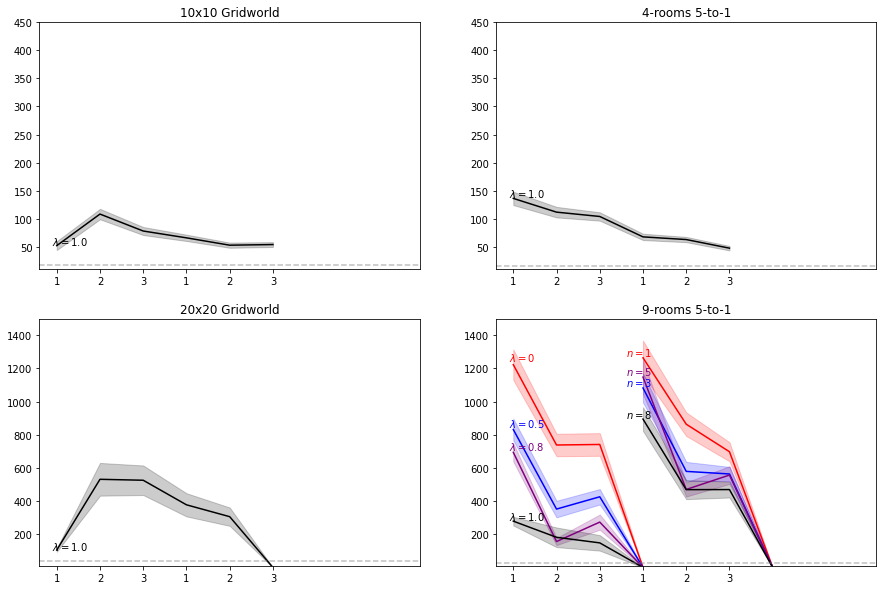

In [77]:
# Define some annotation helper functions
def get_style(**params: dict) -> str:
    v = {1: '-', 2: '--', 3: 'dotted'}
    return v[params['n_levels']]


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'blue', 5: 'purple', 10: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.3: 'green', 0.5: 'blue', 0.8: 'purple', 1.0: 'black'}
        return d[params['decay']]

        
def aggregate(arr: np.ndarray, cutoff: float = 5) -> float:
    episode_means = np.mean(arr, axis=-1)
    stderr = np.std(episode_means, axis=-1)
    mask = np.abs(episode_means - np.mean(episode_means)) < (cutoff * stderr)
    return np.mean(episode_means[mask]), (np.std(episode_means[mask]) / np.sqrt(sum(mask)))


# Create figure
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i % 2, env_i // 2]
    canvas.set_title(environment_labels[env_i])
    
    if not env_i % 2:
        canvas.set_ylim([10, 450])
    else:
        if env_i == 5:
            canvas.set_ylim([10, 4000])
        else:
            canvas.set_ylim([10, 1500])
    
    averages = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        4: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        5: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        6: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
    }
    stds = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        4: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        5: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        6: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
    }
    avg_flat = list()
    std_flat = list()
    
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
        m, s = aggregate(np.asarray(arr)[..., axis][:,0], cutoff=6)
        avg_flat.append(m)
        std_flat.append(s)
    
    
    p_decay = [0, 0.3, 0.5, 0.8, 1.0]
    p_n_steps = [1, 2, 3, 5, 8, 10]
    
    for param_i, (avg, std) in enumerate(zip(avg_flat, std_flat)):
        if meta[param_i]['greedy_options']:
#             continue
            pass
    
        n = meta[param_i]['n_levels']
        if 'decay' in meta[param_i]:
            m = {0.0: 0, 0.3: 1, 0.5: 2, 0.8: 3, 1.0: 4}
            averages[n]['decay'][m[meta[param_i]['decay']]] += (avg - averages[n]['decay'][m[meta[param_i]['decay']]])
            stds[n]['decay'][m[meta[param_i]['decay']]] += (std - stds[n]['decay'][m[meta[param_i]['decay']]])
        else:
            m = {1: 0, 2: 1, 3: 2, 5: 3, 10: 4}
            averages[n]['n_steps'][m[meta[param_i]['n_steps']]] += (avg - averages[n]['n_steps'][m[meta[param_i]['n_steps']]])
            stds[n]['n_steps'][m[meta[param_i]['n_steps']]] += (std - stds[n]['n_steps'][m[meta[param_i]['n_steps']]])
    
    minval = [18, 38, 16, 28, 20, 40][env_i]
    c = ['red', 'green', 'blue', 'purple', 'black']
    for x in range(len(c)):
        if x == 1: 
            continue
        
        decay = np.asarray([v['decay'][x] for v in averages.values()])
        n_steps = np.asarray([v['n_steps'][x] for v in averages.values()])
        
        edecay = np.asarray([v['decay'][x] for v in stds.values()])
        en_steps = np.asarray([v['n_steps'][x] for v in stds.values()])
        
        xs = np.arange(1, 7)
        canvas.plot(xs, decay, color=c[x])
        canvas.fill_between(xs, decay - edecay, decay + edecay, color=c[x], alpha=0.2)
        
        
        canvas.annotate(fr'$\lambda={p_decay[x]}$',
            xy=(xs[0]*0.9, decay[0] * 1.02), xycoords='data', color=c[x])
        
        canvas.plot(xs+3, n_steps, color=c[x])
        canvas.fill_between(xs+3, n_steps - en_steps, n_steps + en_steps, color=c[x], alpha=0.2)
        
        
        canvas.annotate(fr'$n={p_n_steps[x]}$',
            xy=((xs[0]*0.6+3), n_steps[0] * 1.01), xycoords='data', color=c[x])
        
        # Number of hierarchies x-ticks
        canvas.set_xticks(list(range(1, 7)))
        canvas.set_xticklabels([1, 2, 3, 1, 2, 3])
      
    canvas.axhline(minval, 0, 7, color='grey', linestyle='--', alpha=0.5)
#     canvas.set_yscale('log')
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of Hierarchies', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Aggregate number of steps per episode', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps per episode\nAveraged over first 50 episodes and 100 runs.", fontsize=15)

plt.tight_layout()
# plt.savefig('PerformanceResultsAggregate.pdf', format='pdf', bbox_inches="tight")
plt.show()

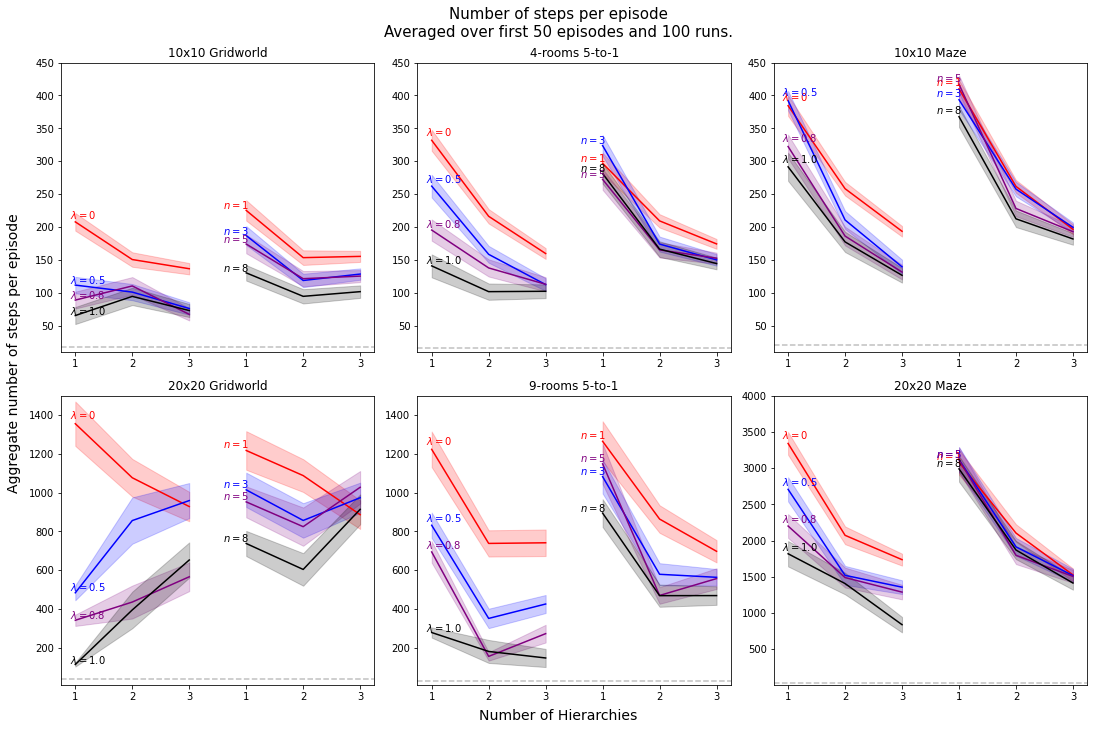

In [181]:
# Define some annotation helper functions
def get_style(**params: dict) -> str:
    v = {1: '-', 2: '--', 3: 'dotted'}
    return v[params['n_levels']]


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'blue', 5: 'purple', 10: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.3: 'green', 0.5: 'blue', 0.8: 'purple', 1.0: 'black'}
        return d[params['decay']]

        
def aggregate(arr: np.ndarray, cutoff: float = 5) -> float:
    episode_means = np.mean(arr, axis=-1)
    stderr = np.std(episode_means, axis=-1)
    mask = np.abs(episode_means - np.mean(episode_means)) < (cutoff * stderr)
    return np.mean(episode_means[mask]), (np.std(episode_means[mask]) / np.sqrt(sum(mask)))


# Create figure
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i % 2, env_i // 2]
    canvas.set_title(environment_labels[env_i])
    
    if not env_i % 2:
        canvas.set_ylim([10, 450])
    else:
        if env_i == 5:
            canvas.set_ylim([10, 4000])
        else:
            canvas.set_ylim([10, 1500])
    
    averages = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5}
    }
    stds = {
        1: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        2: {'decay': [0.] * 5, 'n_steps': [0.] * 5},
        3: {'decay': [0.] * 5, 'n_steps': [0.] * 5}
    }
    avg_flat = list()
    std_flat = list()
    
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
        m, s = aggregate(np.asarray(arr)[..., axis][:,0], cutoff=6)
        avg_flat.append(m)
        std_flat.append(s)
    
    
    p_decay = [0, 0.3, 0.5, 0.8, 1.0]
    p_n_steps = [1, 2, 3, 5, 8, 10]
    
    for param_i, (avg, std) in enumerate(zip(avg_flat, std_flat)):
        if meta[param_i]['greedy_options']:
#             continue
            pass
    
        n = meta[param_i]['n_levels']
        if 'decay' in meta[param_i]:
            m = {0.0: 0, 0.3: 1, 0.5: 2, 0.8: 3, 1.0: 4}
            averages[n]['decay'][m[meta[param_i]['decay']]] += (avg - averages[n]['decay'][m[meta[param_i]['decay']]])
            stds[n]['decay'][m[meta[param_i]['decay']]] += (std - stds[n]['decay'][m[meta[param_i]['decay']]])
        else:
            m = {1: 0, 2: 1, 3: 2, 5: 3, 10: 4}
            averages[n]['n_steps'][m[meta[param_i]['n_steps']]] += (avg - averages[n]['n_steps'][m[meta[param_i]['n_steps']]])
            stds[n]['n_steps'][m[meta[param_i]['n_steps']]] += (std - stds[n]['n_steps'][m[meta[param_i]['n_steps']]])
    
    minval = [18, 38, 16, 28, 20, 40][env_i]
    c = ['red', 'green', 'blue', 'purple', 'black']
    for x in range(len(c)):
        if x == 1: 
            continue
        
        decay = np.asarray([v['decay'][x] for v in averages.values()])
        n_steps = np.asarray([v['n_steps'][x] for v in averages.values()])
        
        edecay = np.asarray([v['decay'][x] for v in stds.values()])
        en_steps = np.asarray([v['n_steps'][x] for v in stds.values()])
        
        xs = np.arange(1, 4)
        canvas.plot(xs, decay, color=c[x])
        canvas.fill_between(xs, decay - edecay, decay + edecay, color=c[x], alpha=0.2)
        
        
        canvas.annotate(fr'$\lambda={p_decay[x]}$',
            xy=(xs[0]*0.9, decay[0] * 1.02), xycoords='data', color=c[x])
        
        canvas.plot(xs+3, n_steps, color=c[x])
        canvas.fill_between(xs+3, n_steps - en_steps, n_steps + en_steps, color=c[x], alpha=0.2)
        
        
        canvas.annotate(fr'$n={p_n_steps[x]}$',
            xy=((xs[0]*0.6+3), n_steps[0] * 1.01), xycoords='data', color=c[x])
        
        # Number of hierarchies x-ticks
        canvas.set_xticks(list(range(1, 7)))
        canvas.set_xticklabels([1, 2, 3, 1, 2, 3])
      
    canvas.axhline(minval, 0, 7, color='grey', linestyle='--', alpha=0.5)
#     canvas.set_yscale('log')
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of Hierarchies', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Aggregate number of steps per episode', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps per episode\nAveraged over first 50 episodes and 100 runs.", fontsize=15)

plt.tight_layout()
plt.savefig('PerformanceResultsAggregate.pdf', format='pdf', bbox_inches="tight")
plt.show()

# Visualize Propagation Experiment

In [99]:
benchmark_data = list()
for e in environment_names:  # The Large environments
    print(e)
    l = [x for x in os.listdir() if e in x and 'performance' in x]
    if l:
        n = l[0]
        print(n)
        with open(n, 'rb') as f:
            benchmark_data += pickle.load(f)

gridworld-v0
propagation_ablation_gridworld-v0_1623531607.out
gridworld-v1
n_rooms-v0
propagation_ablation_n_rooms-v0_1623611724.out
n_rooms-v1
maze-v0
propagation_ablation_maze-v0_1623648794.out
maze-v1


{'n_steps': 3, 'n_levels': 1, 'discount': 0.95, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 6, 'n_levels': 1, 'discount': 0.95, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 9, 'n_levels': 1, 'discount': 0.95, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 12, 'n_levels': 1, 'discount': 0.95, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 1000, 'n_levels': 1, 'discount': 0.95, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 1, 'n_levels': 2, 'discount': 0.86, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 2, 'n_levels': 2, 'discount': 0.86, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 3, 'n_levels': 2, 'discount': 0.86, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 4, 'n_levels': 2, 'discount': 0.86, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 1000, 'n_levels': 2, 'discount': 0.86, 'sarsa': True, 'stationary_filtering': False}
{'n_steps': 3, 'n_levels': 1, 'discount': 0.95, 'sars

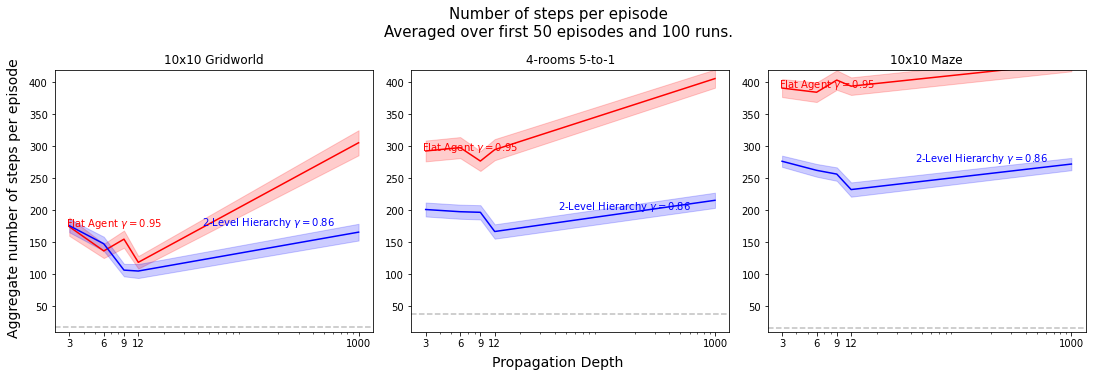

In [174]:
# Define some annotation helper functions
def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'blue', 5: 'purple', 10: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.3: 'green', 0.5: 'blue', 0.8: 'purple', 1.0: 'black'}
        return d[params['decay']]

        
def aggregate(arr: np.ndarray, cutoff: float = 5) -> float:
    episode_means = np.mean(arr, axis=-1)
    stderr = np.std(episode_means, axis=-1)
    mask = np.abs(episode_means - np.mean(episode_means)) < (cutoff * stderr)
    return np.mean(episode_means[mask]), (np.std(episode_means[mask]) / np.sqrt(sum(mask)))


# Create figure
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i]
    canvas.set_title(environment_labels[env_i * 2])
    
    averages = {
        1: {'n_steps': [0.] * 5},
        2: {'n_steps': [0.] * 5}
    }
    stds = {
        1: {'n_steps': [0.] * 5},
        2: {'n_steps': [0.] * 5}
    }
    avg_flat = list()
    std_flat = list()
    
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
        m, s = aggregate(np.asarray(arr)[..., axis][:,0], cutoff=6)
        avg_flat.append(m)
        std_flat.append(s)
    
    p_n_steps = [1, 2, 3, 5, 8, 10]
    
    for param_i, (avg, std) in enumerate(zip(avg_flat, std_flat)):
        if not meta[param_i]['sarsa']:
            continue
        
        if meta[param_i]['stationary_filtering']:
            continue
        
        print(meta[param_i])    
            
        n = meta[param_i]['n_levels']
        if n == 1:
            m = {3: 0, 6: 1, 9: 2, 12: 3, 1000: 4}    
        else:
            m = {1: 0, 2: 1, 3: 2, 4: 3, 1000: 4}
        
        averages[n]['n_steps'][m[meta[param_i]['n_steps']]] += (avg - averages[n]['n_steps'][m[meta[param_i]['n_steps']]])
        stds[n]['n_steps'][m[meta[param_i]['n_steps']]] += (std - stds[n]['n_steps'][m[meta[param_i]['n_steps']]])
    
    minval = [18, 38, 16, 28, 20, 40][env_i]
    c = ['red', 'blue']
    for x in range(len(c)):
        m = np.asarray([3, 6, 9, 12, 1000])
        
        n_steps = np.asarray(averages[x+1]['n_steps'])
        en_steps = np.asarray(stds[x+1]['n_steps'])

        canvas.plot(m, n_steps, color=c[x])
        canvas.fill_between(m, n_steps - en_steps, n_steps + en_steps, color=c[x], alpha=0.2)
        canvas.set_xscale('log')
        canvas.set_ylim([10, 420])
        
        if (x+1) == 1:
            canvas.annotate(r'Flat Agent $\gamma=0.95$',
                xy=((m[0]*0.6+1), n_steps[0]), xycoords='data', color=c[x])
        else:
            canvas.annotate(r'2-Level Hierarchy $\gamma=0.86$',
                xy=((m[0] + 40), n_steps[0]), xycoords='data', color=c[x])
            
        # Number of hierarchies x-ticks
        canvas.set_xticks(list(m))
        canvas.set_xticklabels(m)
      
    canvas.axhline(minval, 0, 7, color='grey', linestyle='--', alpha=0.5)
#     canvas.set_yscale('log')
    
# Plot annotations
fig.text(0.5, -0.02, 'Propagation Depth', fontsize=14, ha='center')
fig.text(-0.01, 0.45, 'Aggregate number of steps per episode', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps per episode\nAveraged over first 50 episodes and 100 runs.", fontsize=15)

plt.tight_layout()
plt.savefig('PropagationHierSARSANoFiltering.pdf', format='pdf', bbox_inches="tight")
plt.show()